# 02. Preparing Coarse-grained Mapped Simulation

## Prequisites

This code requires the `gsd` package, which is available on conda forge.



Coarse-graining a box of 500 methanol molecules from the all atom simulation given in `CG_tutorial/meth.gsd` file.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import hoomd
import hoomd.md
import hoomd.htf as htf
import numpy as np
import gsd, gsd.hoomd, pickle
import matplotlib.pyplot as plt,matplotlib
# disable GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
%matplotlib inline

## Build the Model

Here we prepare the computations that will be executed at each step during the simulation. We have access to the neighbor list, positions, types, box dimensions of the simulation.

We work in four steps:

1. Create a mapping matrix that describes how to group atoms together in a coarse-grained system given the all-atom system
2. Create a coarse-grained mapped trajectory, where atoms are grouped together using the mapping matrix
3. Compute the radial distribution function of this new mapped trajectory
4. Compute the radial distribution function of the C-C from the all-atom sysetm for comparison

In [2]:
# set-up the system
g = gsd.hoomd.open('CG_tutorial/meth.gsd')
c = hoomd.context.initialize('--mode=cpu')
system = hoomd.init.read_gsd(filename='CG_tutorial/meth.gsd')
# disabled particle sorting!
c.sorter.disable()
set_rcut = 10.0

HOOMD-blue 2.5.2 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 04/30/2019
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 6000 particles


In [3]:
#get mapping from molecule index to particle index
molecule_mapping = htf.find_molecules(system)
# get number of atoms
N = sum([len(m) for m in molecule_mapping])
# get number of molecules
M = len(molecule_mapping)
# get number of atoms in a molecule=MN
MN = len(molecule_mapping[0])
# create one bead mapping -> 
# column [[1], [1], [1], [1], [1]] that means 
# all atoms contribute to CG bead equally
# massess are accounted for in sparse_mapping
molecule_mapping_matrix = np.ones([1, MN], dtype=np.int)
#create a mass-weighted M x N mapping operator 
cg_mapping = htf.sparse_mapping([molecule_mapping_matrix for _ in molecule_mapping], 
                                molecule_mapping, system=system)
assert cg_mapping.shape == (M, N)

Finding molecules...99.90%


In [4]:
# define model
class MappingModel(htf.SimModel):
    def setup(self, CG_NN, cg_mapping, rcut):
        self.CG_NN = CG_NN
        self.rcut = rcut
        self.cg_mapping = cg_mapping
        self.avg_cg_rdf = tf.keras.metrics.MeanTensor()
        self.avg_aa_rdf = tf.keras.metrics.MeanTensor()
    def compute(self, nlist, positions, box):
        # calculate the center of mass of a CG bead
        box_size = htf.box_size(box)
        mapped_pos = htf.center_of_mass(positions[:,:3], self.cg_mapping, box_size)
        # create the mapped neighbot list
        mapped_nlist = htf.compute_nlist(mapped_pos, self.rcut, self.CG_NN, box_size, True)
        # compute RDF for mapped and C-C in all-atom
        cg_rdf = htf.compute_rdf(mapped_nlist, [0.1,self.rcut])
        aa_rdf = htf.compute_rdf(nlist, [0.1,self.rcut], positions[:,3], type_i=3, type_j=3)
        self.avg_cg_rdf.update_state(cg_rdf)
        self.avg_aa_rdf.update_state(aa_rdf)
        return
 

In [5]:
# build model. output_forces = False because 
# this model doesn't comptue forces
max_neighbor_est = 256
model = MappingModel(
    max_neighbor_est, 
    CG_NN=max_neighbor_est, 
    cg_mapping=cg_mapping, 
    output_forces=False,
    rcut=set_rcut,
    check_nlist=True)

## Running the simulation

Here we begin a simulation of methanol. This code is a little complex, but not really about hoomd-tf. This is the details of setting-up the force field to simulate methanol (e.g., treating electrostatics, dispersion, thermostat). 

In [6]:
### Hoomd-Sim code ###

tfcompute = htf.tfcompute(model)
nlist = hoomd.md.nlist.cell()

#set-up pppm
charged = hoomd.group.all()
pppm = hoomd.md.charge.pppm(nlist=nlist, group=charged)
pppm.set_params(Nx=32, Ny=32, Nz=32, order=6, rcut=set_rcut)

#set-up pair coefficients
nlist.reset_exclusions(['1-2', '1-3', '1-4','body'])
lj = hoomd.md.pair.force_shifted_lj(r_cut=set_rcut, nlist=nlist)
forces = [lj]
lj.pair_coeff.set("opls_156", "opls_156", sigma=2.5, epsilon=0.03)
lj.pair_coeff.set("opls_156", "opls_157", sigma=2.96, epsilon=0.05)
lj.pair_coeff.set("opls_156", "opls_154", sigma=2.79, epsilon=0.07)
lj.pair_coeff.set("opls_156", "opls_155", sigma=5.0, epsilon=0.0)
lj.pair_coeff.set("opls_157", "opls_157", sigma=3.5, epsilon=0.07)
lj.pair_coeff.set("opls_157", "opls_154", sigma=3.31, epsilon=0.11)
lj.pair_coeff.set("opls_157", "opls_155", sigma=5.92, epsilon=0.0)
lj.pair_coeff.set("opls_154", "opls_154", sigma=3.12, epsilon=0.17)
lj.pair_coeff.set("opls_154", "opls_155", sigma=5.59, epsilon=0.0)
lj.pair_coeff.set("opls_155", "opls_155", sigma=10.0, epsilon=0.0)

#set-up bonds
harmonic = hoomd.md.bond.harmonic()
harmonic.bond_coeff.set("opls_156-opls_157", k=340.00, r0=1.09)
harmonic.bond_coeff.set("opls_154-opls_157", k=320.00, r0=1.41)
harmonic.bond_coeff.set("opls_154-opls_155", k=553.00, r0=0.95)

#set-up angles
harm_angle = hoomd.md.angle.harmonic()
harm_angle.angle_coeff.set("opls_154-opls_157-opls_156", k=70.0, t0=1.90)
harm_angle.angle_coeff.set("opls_155-opls_154-opls_157", k=110.0, t0=1.89)
harm_angle.angle_coeff.set("opls_156-opls_157-opls_156", k=66.0, t0=1.88)

#set-up dihedrals
dihedral = hoomd.md.dihedral.opls()
dihedral.dihedral_coeff.set("opls_155-opls_154-opls_157-opls_156", k1=0.0, k2=0.0, k3=0.45, k4=0.0)

group_all = hoomd.group.all()
kT = 1.9872/1000

#NVT Simulation in Hoomd
im = hoomd.md.integrate.mode_standard(dt=5.0/489.0)
nvt = hoomd.md.integrate.nvt(group=group_all, kT=298.15 * kT, tau=350 / 48.9)
nvt.randomize_velocities(1234)

tfcompute.attach(nlist, r_cut=set_rcut)

#Hoomd production run
hoomd.run(250)

-----
You are using PPPM. Please cite the following:
* D N LeBard, B G Levine, S A Barr, A Jusufi, S Sanders, M L Klein, and A Z
  Panagiotopoulos. "Self-assembly of coarse-grained ionic surfactants
  accelerated by graphics processing units", Journal of Computational Physics 8
  (2012) 2385-2397
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 5 exclusions             : 6000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
notice(2): Force mode is FORCE_MODE.hoomd2tf 
notice(2): Starting TensorflowCompute 
notice(2): completed reallocate
** starting run **


*Warning*: charge.pppm: system is not neutral and unscreened interactions are calculated, the net charge is -0.000357628


notice(2): charge.pppm: RMS error: 0.000406376
Time 00:00:15 | Step 11 / 250 | TPS 1.06612 | ETA 00:03:44
Time 00:00:26 | Step 26 / 250 | TPS 1.41869 | ETA 00:02:37
Time 00:00:36 | Step 40 / 250 | TPS 1.38049 | ETA 00:02:32
Time 00:00:46 | Step 54 / 250 | TPS 1.38305 | ETA 00:02:21
Time 00:00:56 | Step 68 / 250 | TPS 1.39376 | ETA 00:02:10
Time 00:01:07 | Step 82 / 250 | TPS 1.33884 | ETA 00:02:05
Time 00:01:17 | Step 96 / 250 | TPS 1.38222 | ETA 00:01:51
Time 00:01:27 | Step 111 / 250 | TPS 1.43404 | ETA 00:01:36
Time 00:01:37 | Step 125 / 250 | TPS 1.38391 | ETA 00:01:30
Time 00:01:48 | Step 140 / 250 | TPS 1.39937 | ETA 00:01:18
Time 00:01:58 | Step 154 / 250 | TPS 1.36845 | ETA 00:01:10
Time 00:02:08 | Step 168 / 250 | TPS 1.39589 | ETA 00:00:58
Time 00:02:19 | Step 183 / 250 | TPS 1.3939 | ETA 00:00:48
Time 00:02:29 | Step 198 / 250 | TPS 1.44138 | ETA 00:00:36
Time 00:02:40 | Step 212 / 250 | TPS 1.38916 | ETA 00:00:27
Time 00:02:50 | Step 227 / 250 | TPS 1.41874 | ETA 00:00:16
T

## Analysis

Now we load the RDF we computed and plot it. Note this is not actually coarse-grained, 
we're just looking at the mapped rdf which can then be used for coarse-graining.

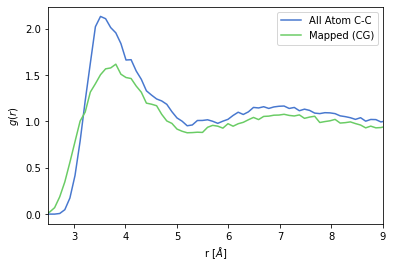

In [7]:
## Plot RDFs between Mapped CG beads (center of masses) and the reference (C-O in all atom system )
matplotlib.style.use('seaborn-muted')
aa_rdf = model.avg_aa_rdf.result().numpy()
cg_rdf = model.avg_cg_rdf.result().numpy()
r = aa_rdf[1,:]
plt.plot(aa_rdf[1,:], aa_rdf[0,:] / aa_rdf[0,-1],label ='All Atom C-C')
plt.plot(cg_rdf[1,:], cg_rdf[0,:] / cg_rdf[0,-1], label='Mapped (CG)')
plt.xlim(2.5,9)
plt.xlabel(r'r [$\AA$]')
plt.ylabel('$g(r)$')
plt.legend()
plt.show()